# Libraries and Modules

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Models
## Linear Regression is used as a baseline model
from sklearn.linear_model import LinearRegression

## Random Forest, XGB and Gradient Boosting are experimented for better performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

## Support Vector Machine is useful for non-linear data
from sklearn.svm import SVR


# Model Parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Model Evaluation
## For Regression Models we use MAE, MSE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Recommendations

Begin with Linear Regression as a baseline.

Experiment with Random Forest and XGBoost/LightGBM for better performance.

If you suspect non-linear relationships, try SVR or Neural Networks.

Use Ensemble methods for combining predictions from multiple models.

# Data Import

In [2]:
df_test = pd.read_csv(r'Dataset\Test_dataset.csv')
df_train = pd.read_csv(r'Dataset\Train_dataset.csv')

# Exploratory Data Analysis (EDA)

## 1. Data Structure
- Columns: Check column data, compare test with train data
- Data Types: Check the data types of each column.
- Missing Values: Identify and handle missing values.
- Basic Statistics: Calculate basic statistics like mean, median, standard deviation, etc.

### Columns

In [3]:
train_columns = set(df_train.columns)
test_columns = set(df_test.columns)

# Identify columns present in train but missing in test
missing_in_test = train_columns - test_columns

# Identify columns present in test but missing in train
missing_in_train = test_columns - train_columns

# Print the results
if missing_in_test:
    print("Columns present in train but missing in test:")
    print(missing_in_test)
else:
    print("No columns are missing in test dataset.")

if missing_in_train:
    print("Columns present in test but missing in train:")
    print(missing_in_train)
else:
    print("No columns are missing in train dataset.")

Columns present in train but missing in test:
{'Annual Turnover', 'Endorsed By'}
Columns present in test but missing in train:
{'Endoresed By'}


In [4]:
# Fix the column name
df_test.rename(columns={'Endoresed By':'Endorsed By'}, inplace=True)

### Data types

In [5]:
dtype_train = df_train.drop(columns=['Annual Turnover']).dtypes
dtype_test = df_test.dtypes

# Align the indices of the two Series objects
dtype_test = dtype_test.reindex(dtype_train.index)

# Compare data types
dtype_diff = dtype_train.compare(dtype_test)

# Print the differences
if not dtype_diff.empty:
    print("Differences in data types between train and test datasets:")
    print(dtype_diff)
else:
    print("All columns have matching data types in train and test datasets.")

Differences in data types between train and test datasets:
                   self  other
Resturant Tier  float64  int64
Ambience        float64  int64


In [6]:
df_train['Resturant Tier'].value_counts()

Resturant Tier
2.0    3191
1.0     253
Name: count, dtype: int64

In [7]:
df_train['Ambience'].value_counts().sort_index(ascending=False)

Ambience
10.0    167
9.0     348
8.0     665
7.0     596
6.0     679
5.0     368
4.0     349
3.0     150
2.0      96
1.0      29
0.0      21
Name: count, dtype: int64

In [8]:
# Match the data types of the two datasets
df_test['Resturant Tier'] = df_test['Resturant Tier'].astype(float)
df_test['Ambience'] = df_test['Ambience'].astype(float)

# Could not convert train['Ambience'] and train['Resturant Tier'] to int as they contain NaN values

- Note:

Now that data types are alined we can check df_train data types and any changes made will be replicated on to df_test. This step could have been done before checking for differences but I didn't think of it until now and don't want to change it

In [9]:
def change_col_type(col_name, dtype):
    '''
    Change the data type of a column in both train and test datasets.
    '''
    df_train[col_name] = df_train[col_name].astype(dtype)
    df_test[col_name] = df_test[col_name].astype(dtype)

In [10]:
change_col_type('Opening Day of Restaurant', 'datetime64[ns]')

col_bool = ['Fire Audit', 'Liquor License Obtained', 'Situated in a Multi Complex', 'Dedicated Parking', 'Open Sitting Available']

for col in col_bool:
    change_col_type(col, 'bool')

In [11]:
df_test.dtypes

Registration Number                       int64
Cuisine                                  object
City                                     object
Restaurant Location                      object
Opening Day of Restaurant        datetime64[ns]
Facebook Popularity Quotient            float64
Endorsed By                              object
Instagram Popularity Quotient           float64
Fire Audit                                 bool
Liquor License Obtained                    bool
Situated in a Multi Complex                bool
Dedicated Parking                          bool
Open Sitting Available                     bool
Resturant Tier                          float64
Restaurant Type                          object
Restaurant Theme                         object
Restaurant Zomato Rating                  int64
Restaurant City Tier                      int64
Order Wait Time                           int64
Staff Responsivness                       int64
Value for Money                         

- Note:

Since both column types match a final inspection of only one is needed.

### Missing Values


In [12]:
df_train.shape

(3493, 34)

In [13]:
# show missing values only
df_train.isna().sum()[df_train.isna().sum() > 0]

Facebook Popularity Quotient       99
Instagram Popularity Quotient      56
Resturant Tier                     49
Overall Restaurant Rating         212
Live Music Rating                 765
Comedy Gigs Rating               2483
Value Deals Rating               2707
Live Sports Rating               3288
Ambience                           25
dtype: int64

In [14]:
df_test.isna().sum()[df_test.isna().sum() > 0]

Overall Restaurant Rating     34
Live Music Rating            102
Comedy Gigs Rating           370
Value Deals Rating           385
Live Sports Rating           471
dtype: int64

- Note: 

A deep dive into the data reveals that the missing values for _Live Music Rating_, _Comedy Gigs Rating_, _Value Deals Rating_, _Live Sports Rating_ means the venue does not offer those services. **New indicator columns will display this difference**. 

The Missing **values will be kept as NaN for the time being** since some models can handle them and others can't, further on the values will be changed depending on the model's requirements.

_Overall Resturant Rating_ missing values will be **dropped**.

In [15]:
# Create a new column indicating whether the service is available
def create_has_service(col_name):
    '''
    Create a new column indicating whether the service is available and removing 'Ratings' from new colummns name.
    '''
    df_train['Has ' + col_name.replace(' Rating','')] = df_train[col_name].notna()
    df_test['Has ' + col_name.replace(' Ratings','')] = df_test[col_name].notna()

In [16]:
services_cols = ['Live Music Rating', 'Comedy Gigs Rating', 'Value Deals Rating', 'Live Sports Rating']

for col in services_cols:
    create_has_service(col)

In [17]:
# Drop Overall Restaurant Rating Missing values
df_train.dropna(subset=['Overall Restaurant Rating'], inplace=True)
df_test.dropna(subset=['Overall Restaurant Rating'], inplace=True)

### Basic Statistics (describe)

#### Describe Numeric

In [19]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
Registration Number,3281.0,61745.664736,60001.0,60868.0,61740.0,62622.0,63492.0,1011.078684
Annual Turnover,3281.0,30767570.862542,3500000.0,18000000.0,30000000.0,37500000.0,400000000.0,21206162.16773
Opening Day of Restaurant,3281,2009-11-23 09:07:17.793355776,1996-10-25 00:00:00,2008-10-29 00:00:00,2010-02-28 00:00:00,2011-03-02 00:00:00,2013-12-25 00:00:00,NaN
Facebook Popularity Quotient,3189.0,77.940665,43.0,72.0,79.0,85.73,97.76,9.830594
Instagram Popularity Quotient,3228.0,74.352203,40.0,66.0,74.0,82.2,98.2,10.918302
Resturant Tier,3234.0,1.927025,1.0,2.0,2.0,2.0,2.0,0.260135
Restaurant Zomato Rating,3281.0,2.699177,0.0,2.0,3.0,3.0,5.0,0.786333
Restaurant City Tier,3281.0,0.303261,0.0,0.0,0.0,1.0,1.0,0.459737
Order Wait Time,3281.0,5.505639,1.0,3.0,5.0,8.0,10.0,2.855255
Staff Responsivness,3281.0,4.525754,1.0,4.0,5.0,5.0,8.0,1.092948


In [20]:
df_test.describe().T

,count,mean,min,25%,50%,75%,max,std
Registration Number,466.0,20251.169528,20001.0,20124.25,20252.5,20377.75,20500.0,144.963945
Opening Day of Restaurant,466,2009-12-20 02:53:02.832617984,2003-01-06 00:00:00,2008-12-04 18:00:00,2010-03-27 00:00:00,2011-02-26 12:00:00,2014-05-07 00:00:00,NaN
Facebook Popularity Quotient,466.0,77.446652,46.0,70.5,79.0,85.0,96.8,10.153523
Instagram Popularity Quotient,466.0,74.669013,47.0,65.615,74.815,83.46,97.2,11.311612
Resturant Tier,466.0,1.935622,1.0,2.0,2.0,2.0,2.0,0.245688
Restaurant Zomato Rating,466.0,2.706009,1.0,2.0,3.0,3.0,5.0,0.768637
Restaurant City Tier,466.0,0.287554,0.0,0.0,0.0,1.0,1.0,0.453108
Order Wait Time,466.0,5.598712,1.0,3.0,6.0,8.0,10.0,2.924851
Staff Responsivness,466.0,4.562232,2.0,4.0,5.0,5.0,7.0,1.058194
Value for Money,466.0,4.517167,2.0,4.0,5.0,5.0,7.0,0.882765


#### Describe Object

In [23]:
df_train.describe(include='object').T

,count,unique,top,freq
Cuisine,3281,20,"tibetan,greek",645
City,3281,282,Bangalore,525
Restaurant Location,3281,2,Near Party Hub,2484
Endorsed By,3281,3,Not Specific,1832
Restaurant Type,3281,3,Bar,3044
Restaurant Theme,3281,23,Arabian,1335


In [22]:
df_test.describe(include=[object]).T

,count,unique,top,freq
Cuisine,466,20,"tibetan,greek",109
City,466,92,Bangalore,72
Restaurant Location,466,2,Near Party Hub,353
Endorsed By,466,3,Not Specific,277
Restaurant Type,466,4,Bar,429
Restaurant Theme,466,13,Arabian,214


## 2. Univariate Analysis
- Distribution of Numerical Features: Use histograms, box plots, and density plots.
- Distribution of Categorical Features: Use bar plots and count plots.

### Distribution of Numerical Features

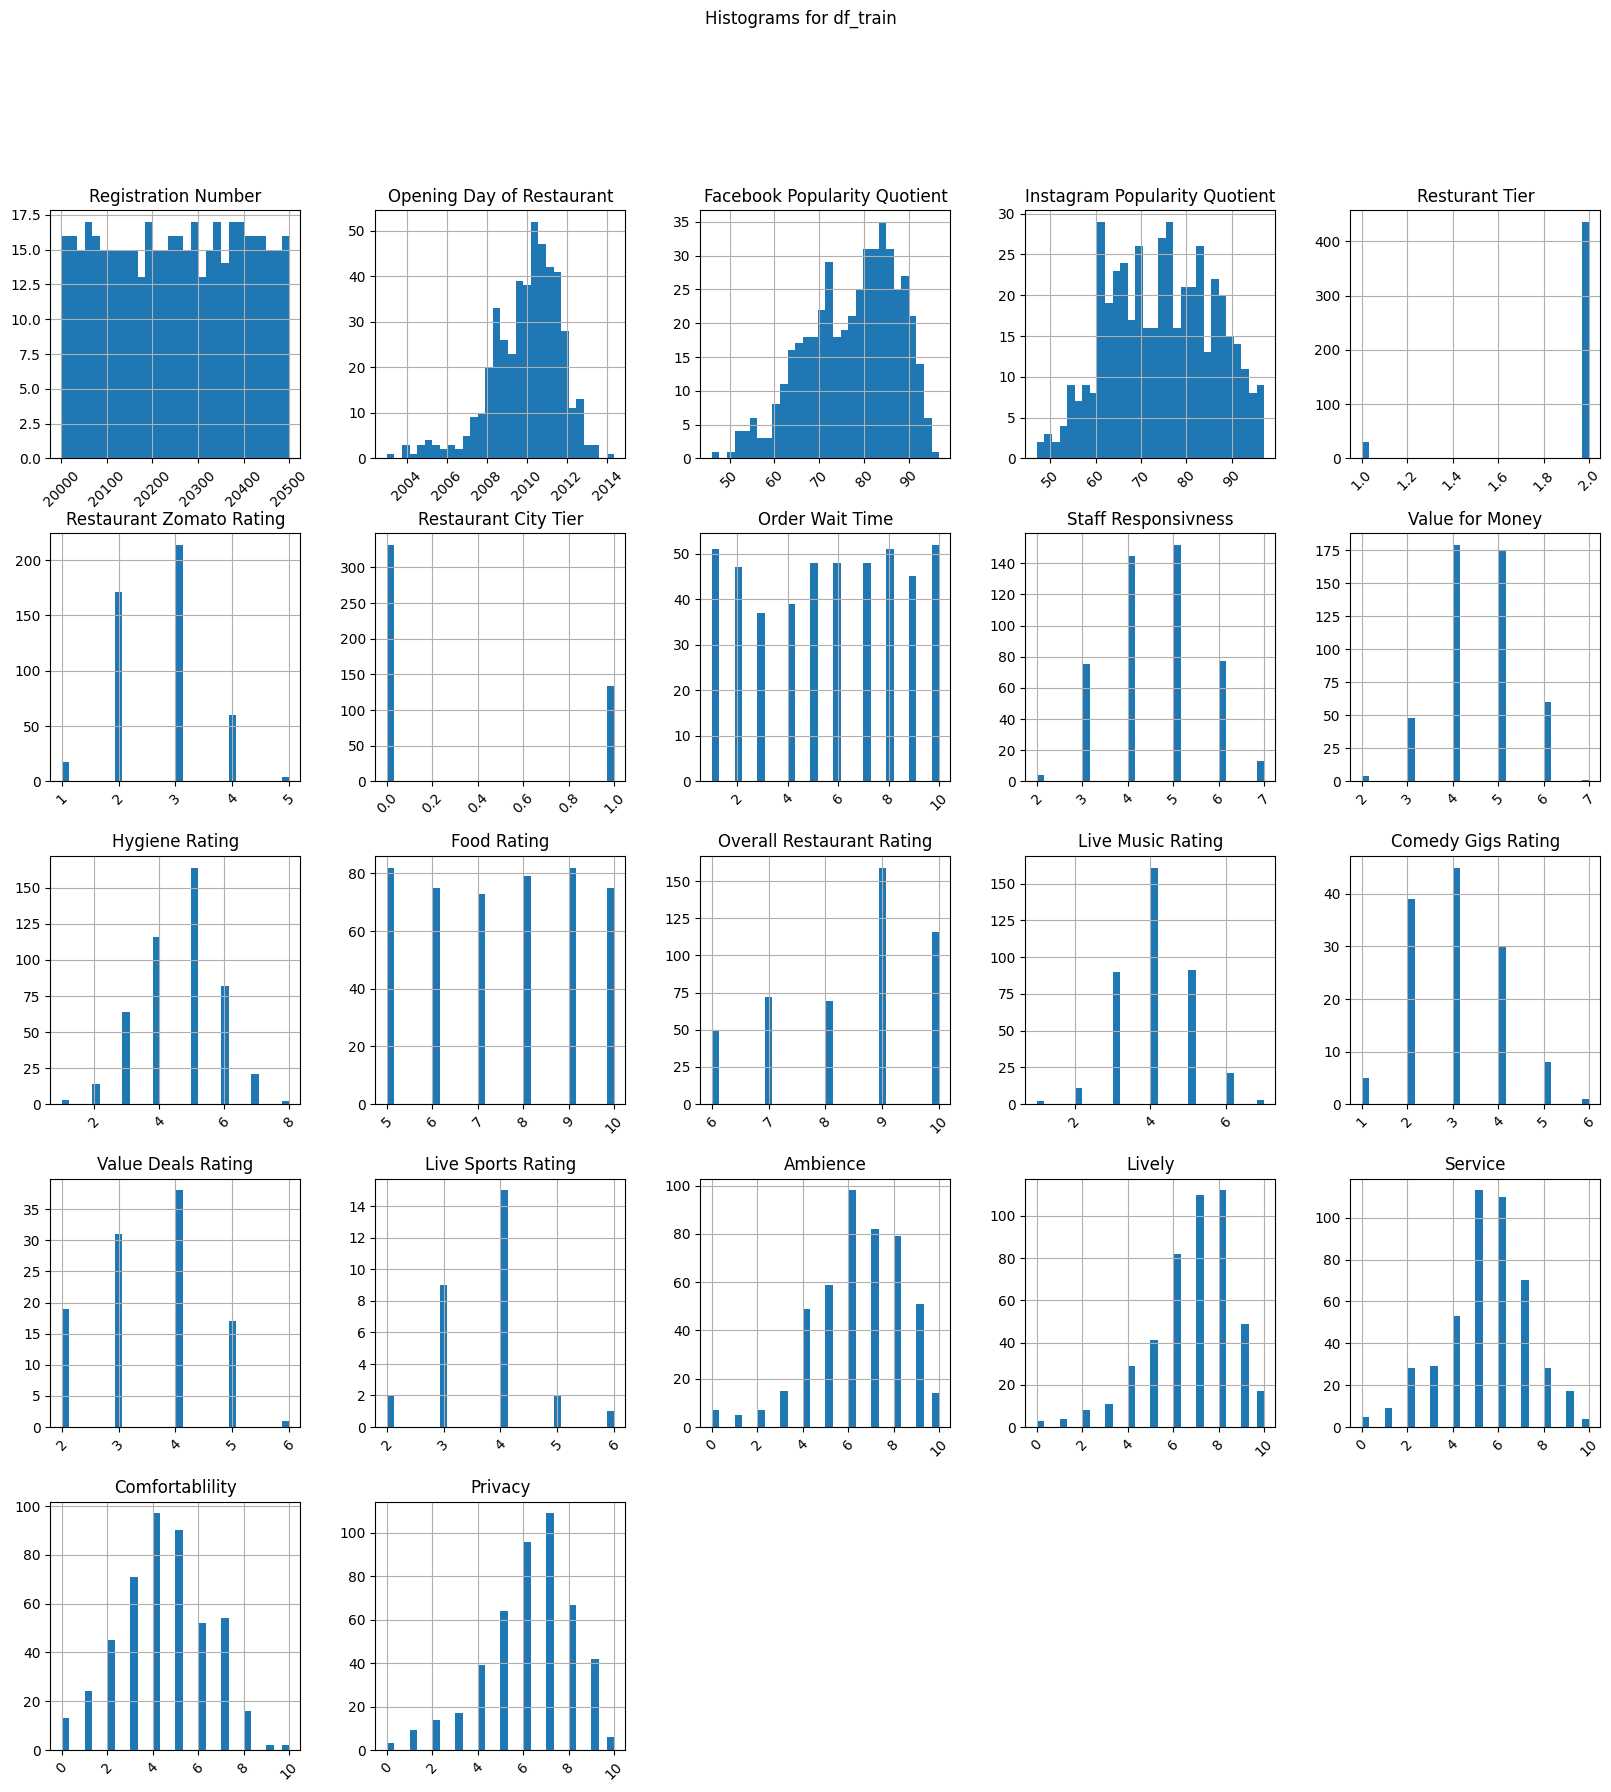

In [ ]:
axes = df_test.hist(bins=30, figsize=(20, 20))
plt.suptitle('Histograms for df_train')
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

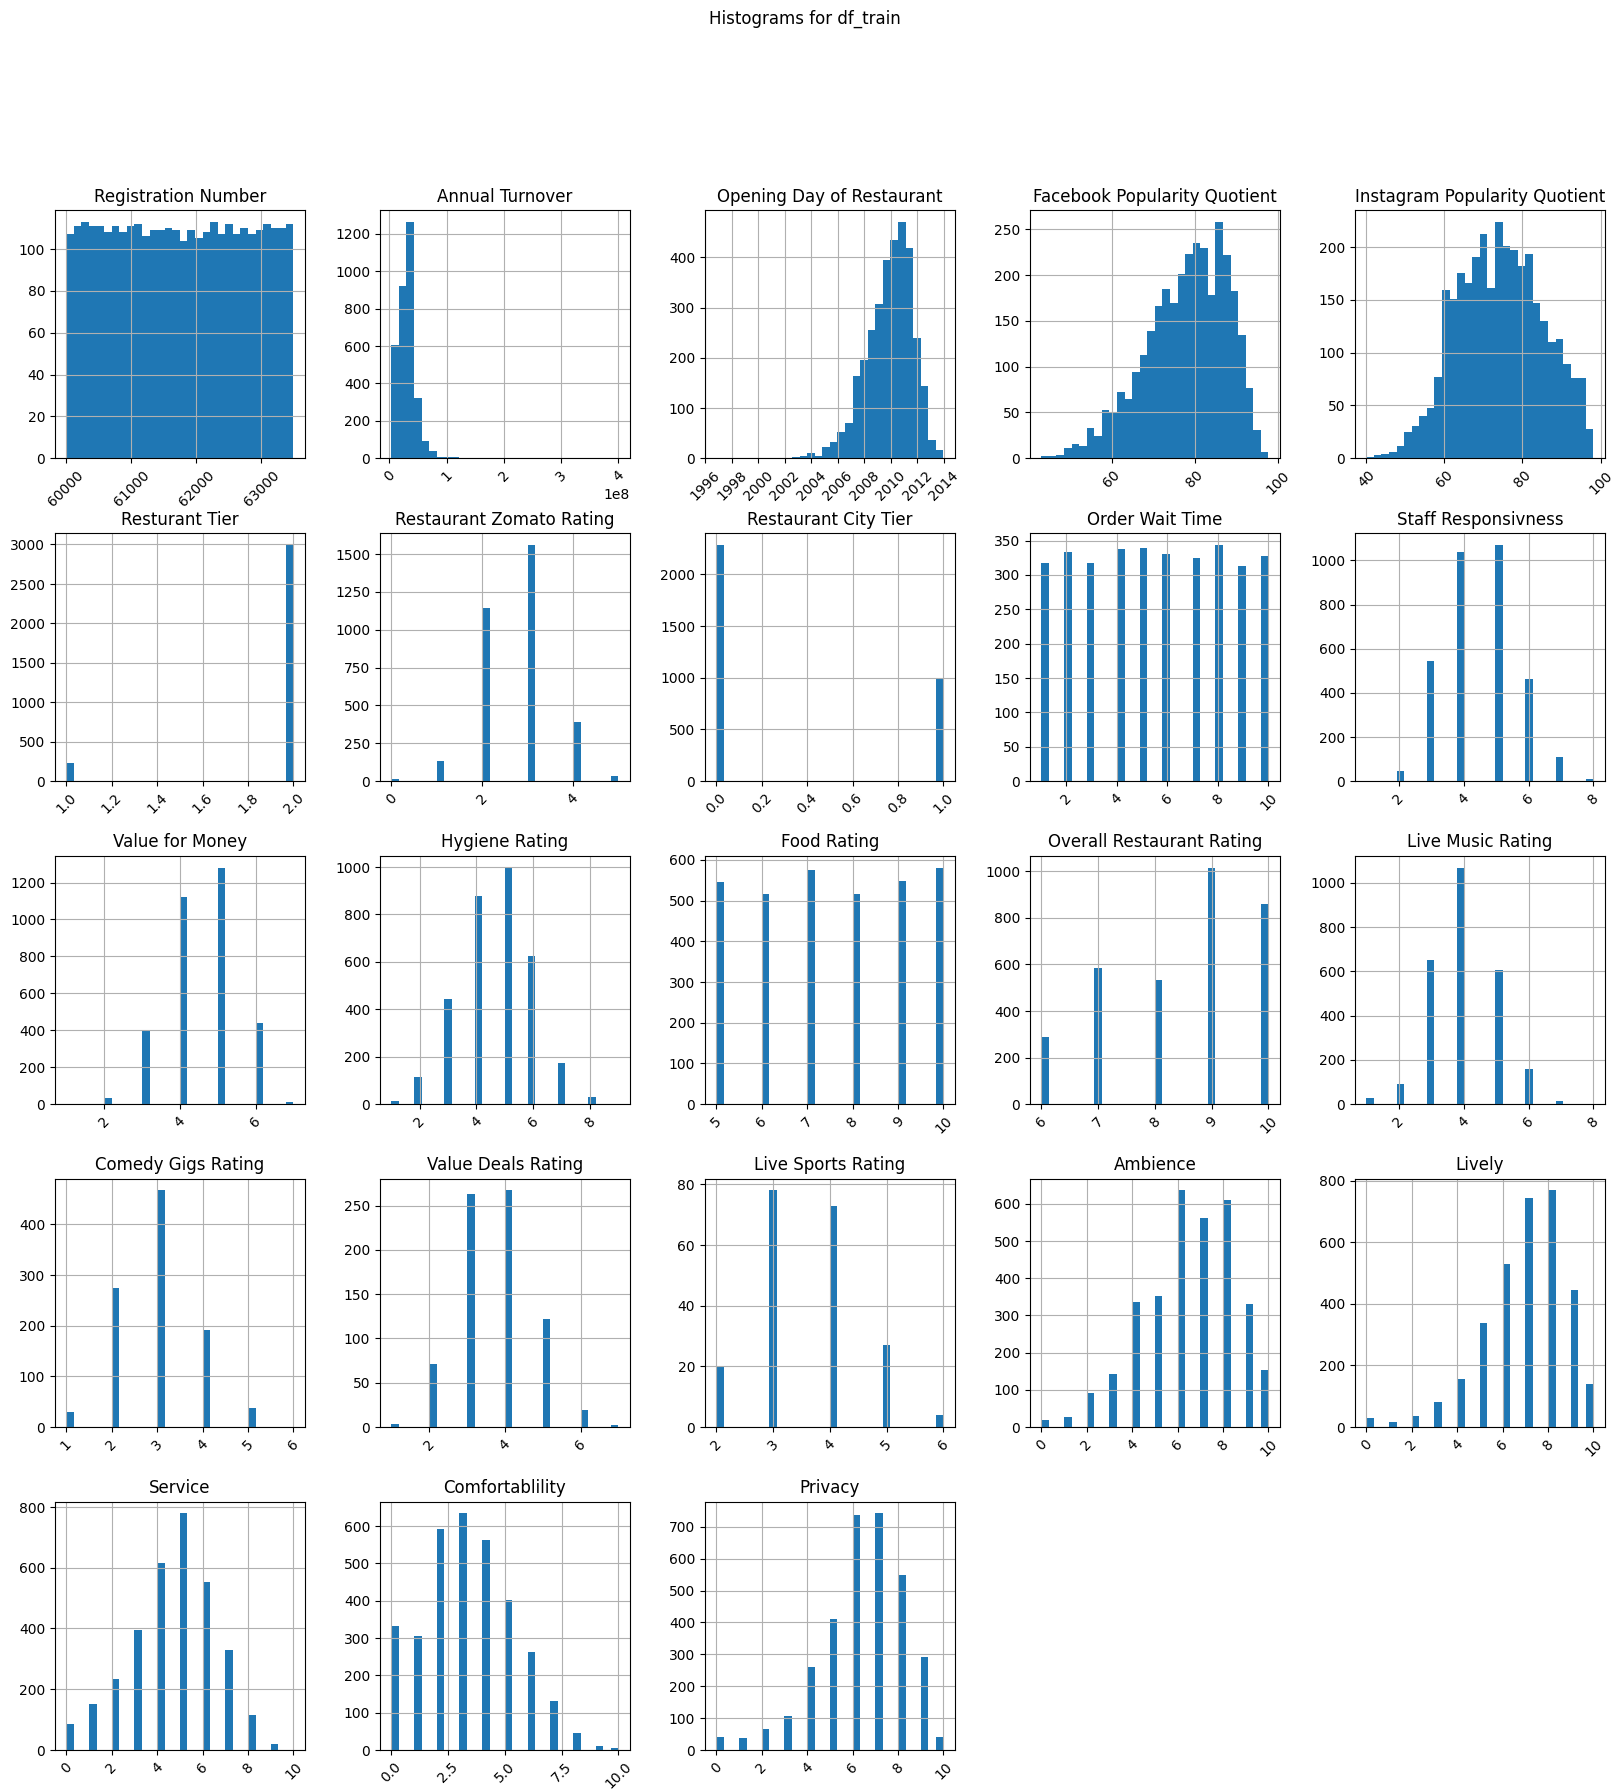

In [35]:
axes = df_train.hist(bins=30, figsize=(20, 20))
plt.suptitle('Histograms for df_train')
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [65]:
def create_density_plots(df, title):
    '''
    Function to create density plots for all numerical columns in a DataFrame.
    '''
    num_columns = df.select_dtypes(include=['number']).columns
    num_plots = len(num_columns)
    num_rows = (num_plots + 2) // 3  # Adjust the number of columns per row as needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
    fig.suptitle(title, fontsize=16)
    
    for i, col in enumerate(num_columns):
        ax = axes.flatten()[i]
        sns.kdeplot(df[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Density')
    
    # Remove empty subplots
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()


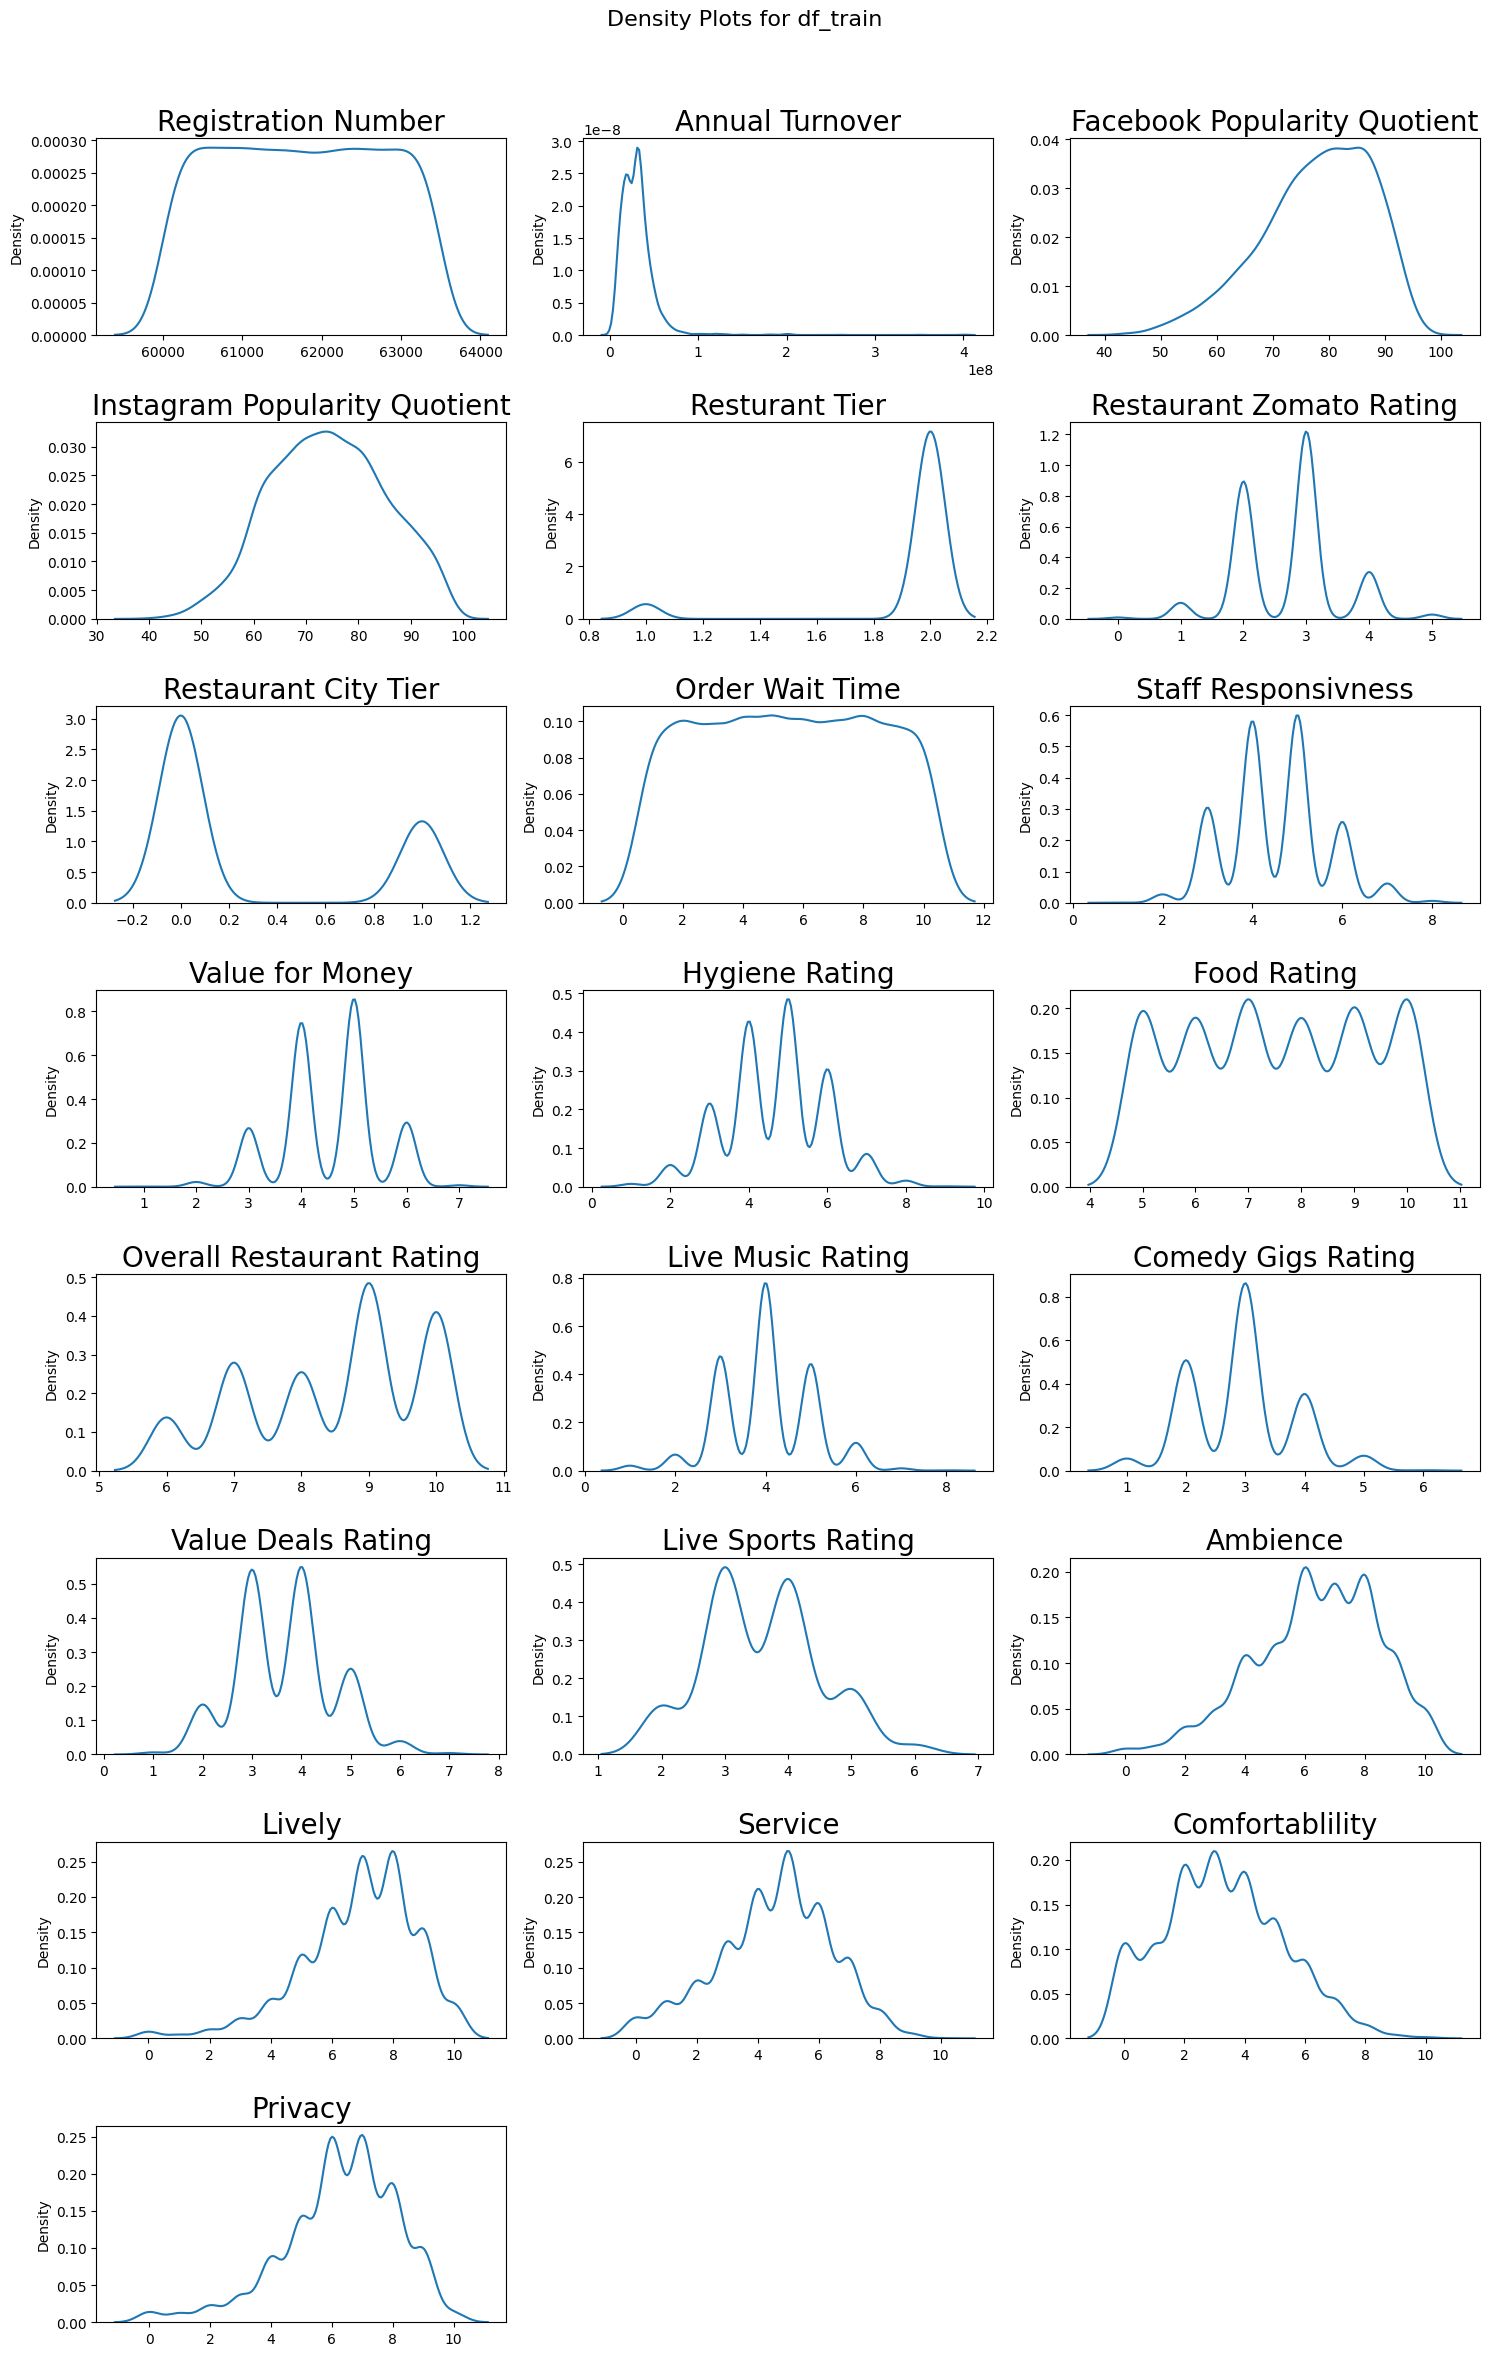

In [66]:
# Create density plots for df_train
create_density_plots(df_train, 'Density Plots for df_train')

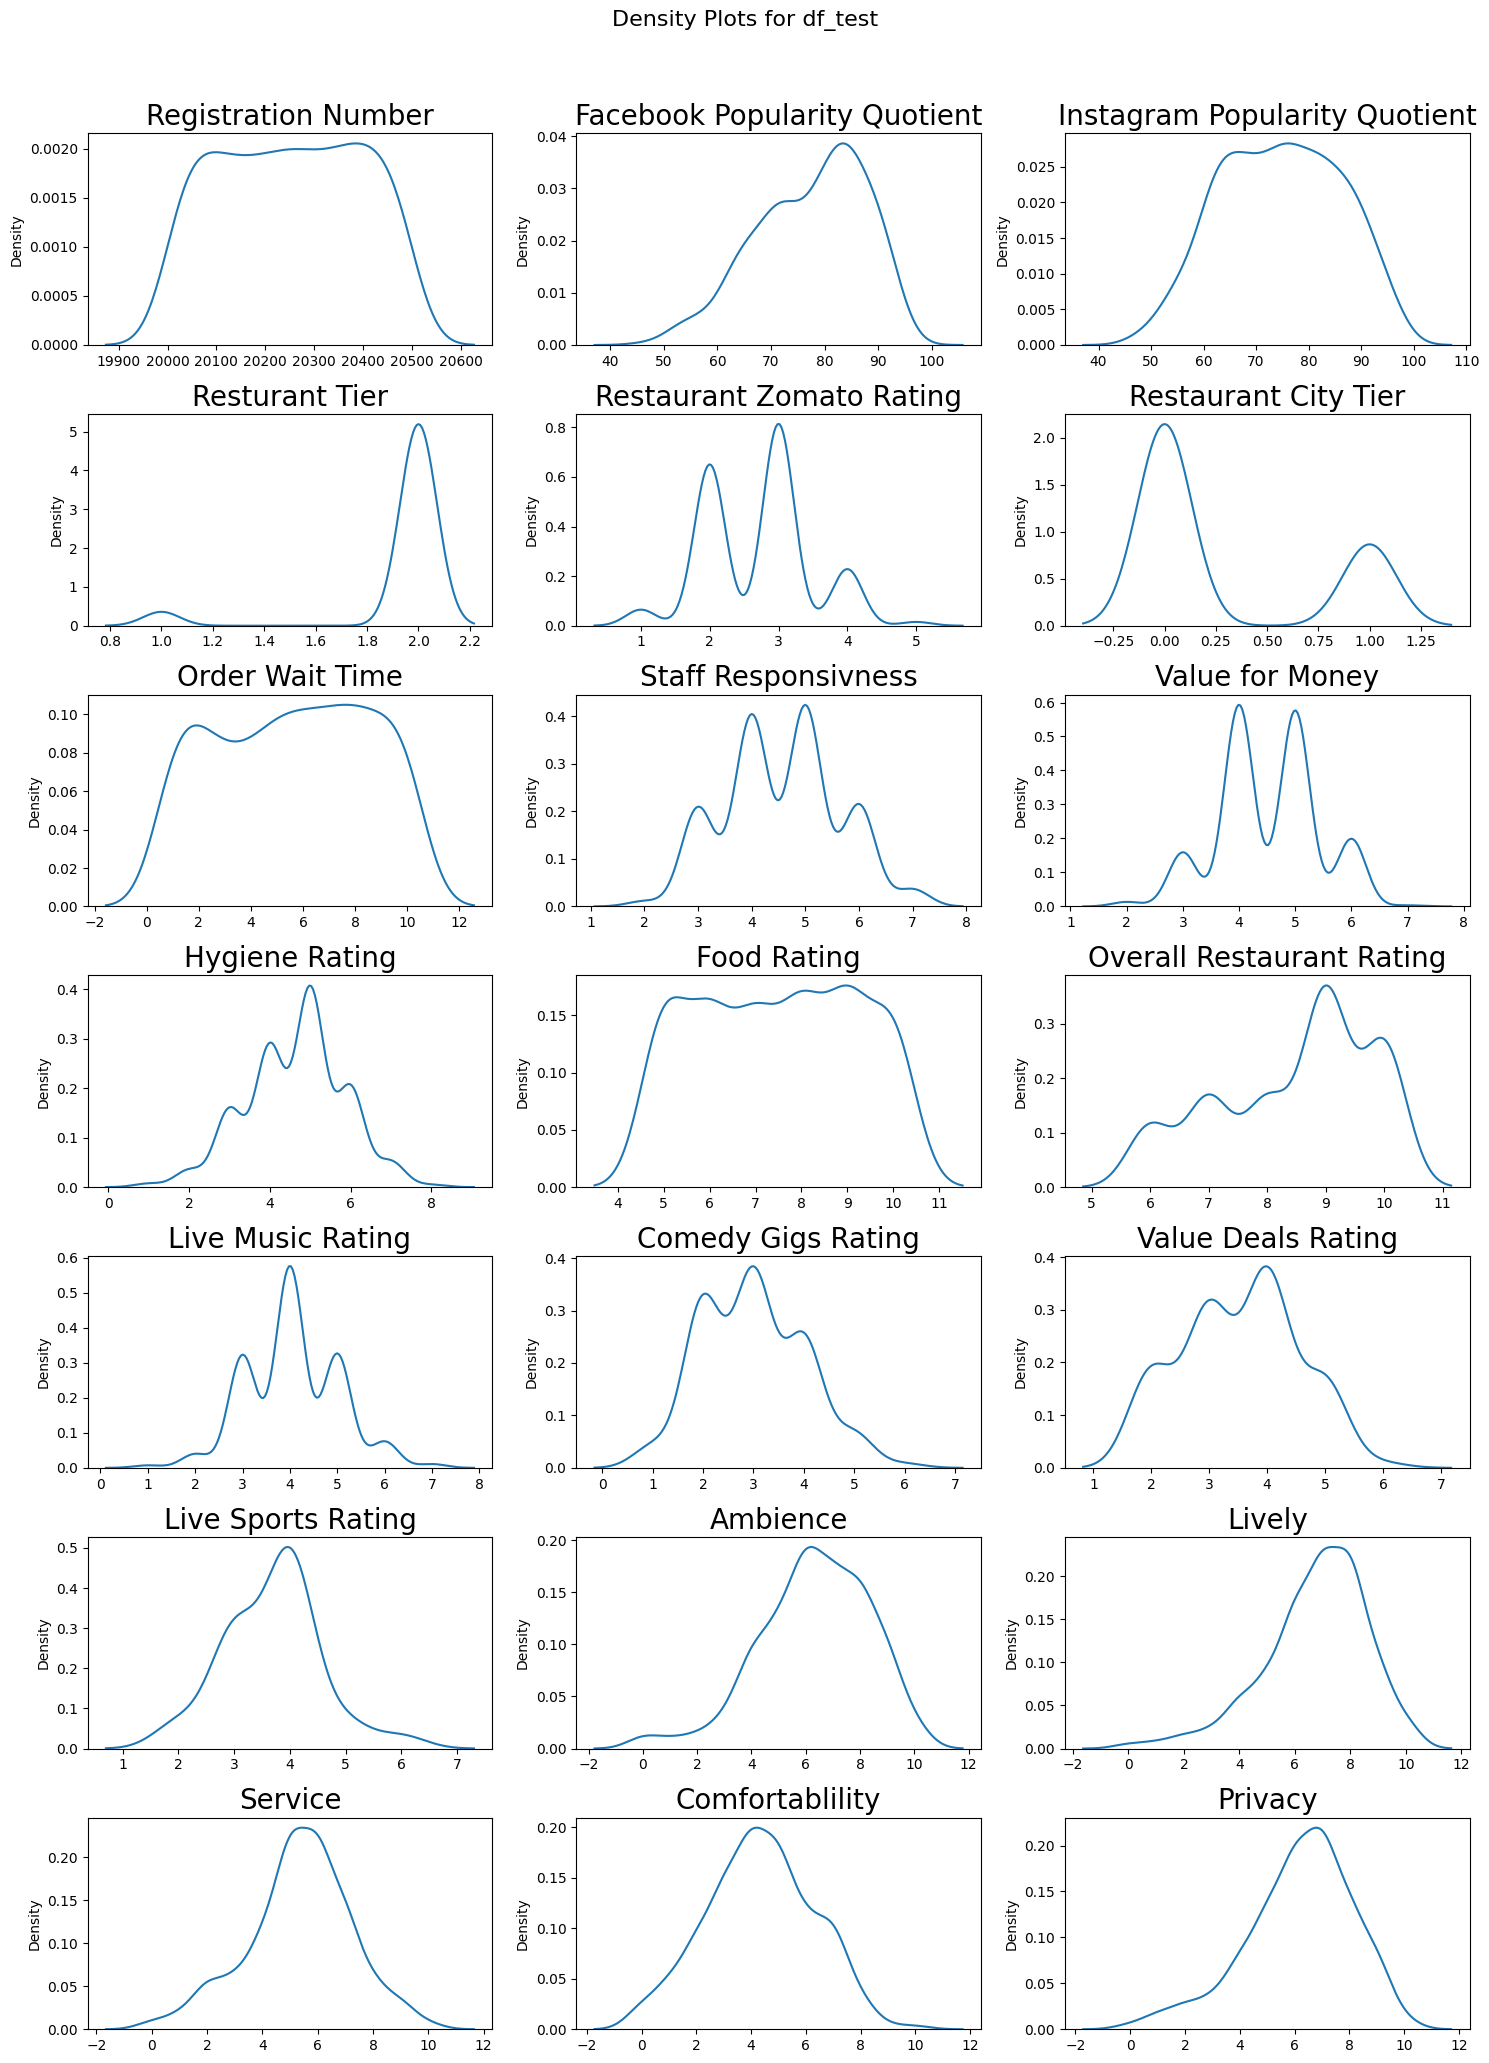

In [59]:
create_density_plots(df_test, 'Density Plots for df_test')

In [60]:
# Function to create boxplots for a DataFrame
def create_boxplots(df, title):
    num_columns = df.select_dtypes(include=['number']).columns
    num_plots = len(num_columns)
    num_rows = (num_plots + 2) // 3  # Adjust the number of columns per row as needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
    fig.suptitle(title, fontsize=16)
    
    for i, col in enumerate(num_columns):
        ax = axes.flatten()[i]
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Value')
    
    # Remove empty subplots
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

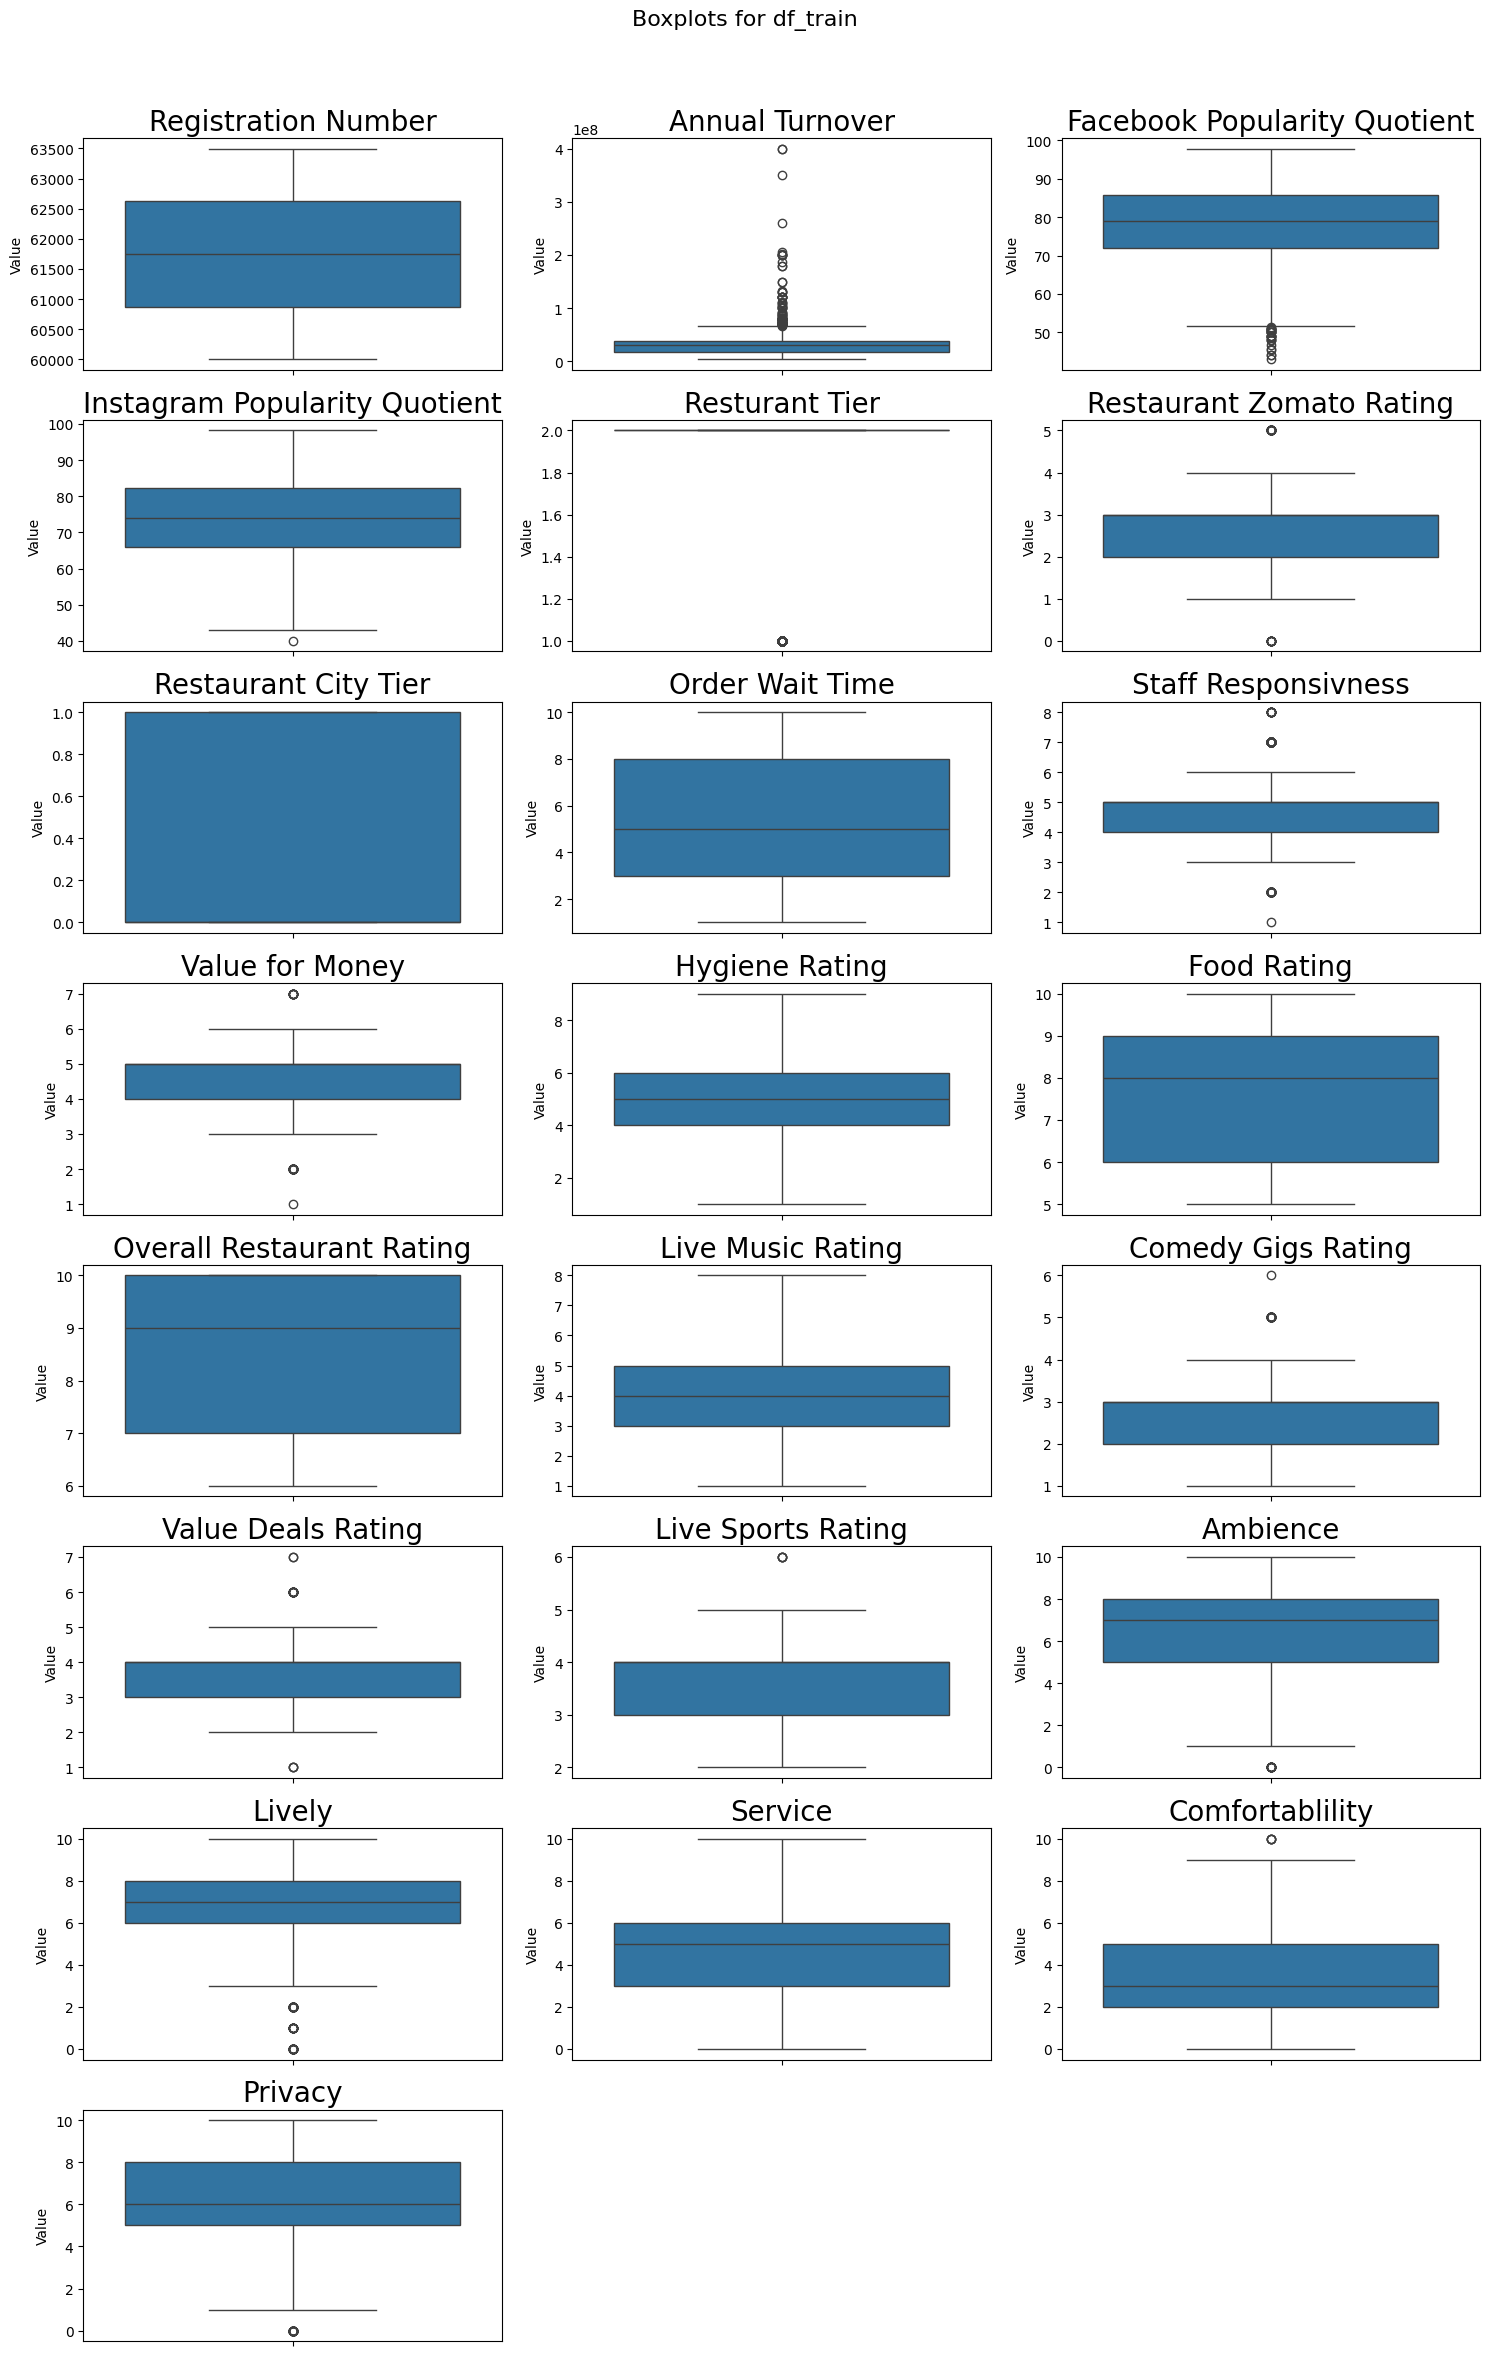

In [61]:
# Create boxplots for df_train
create_boxplots(df_train, 'Boxplots for df_train')

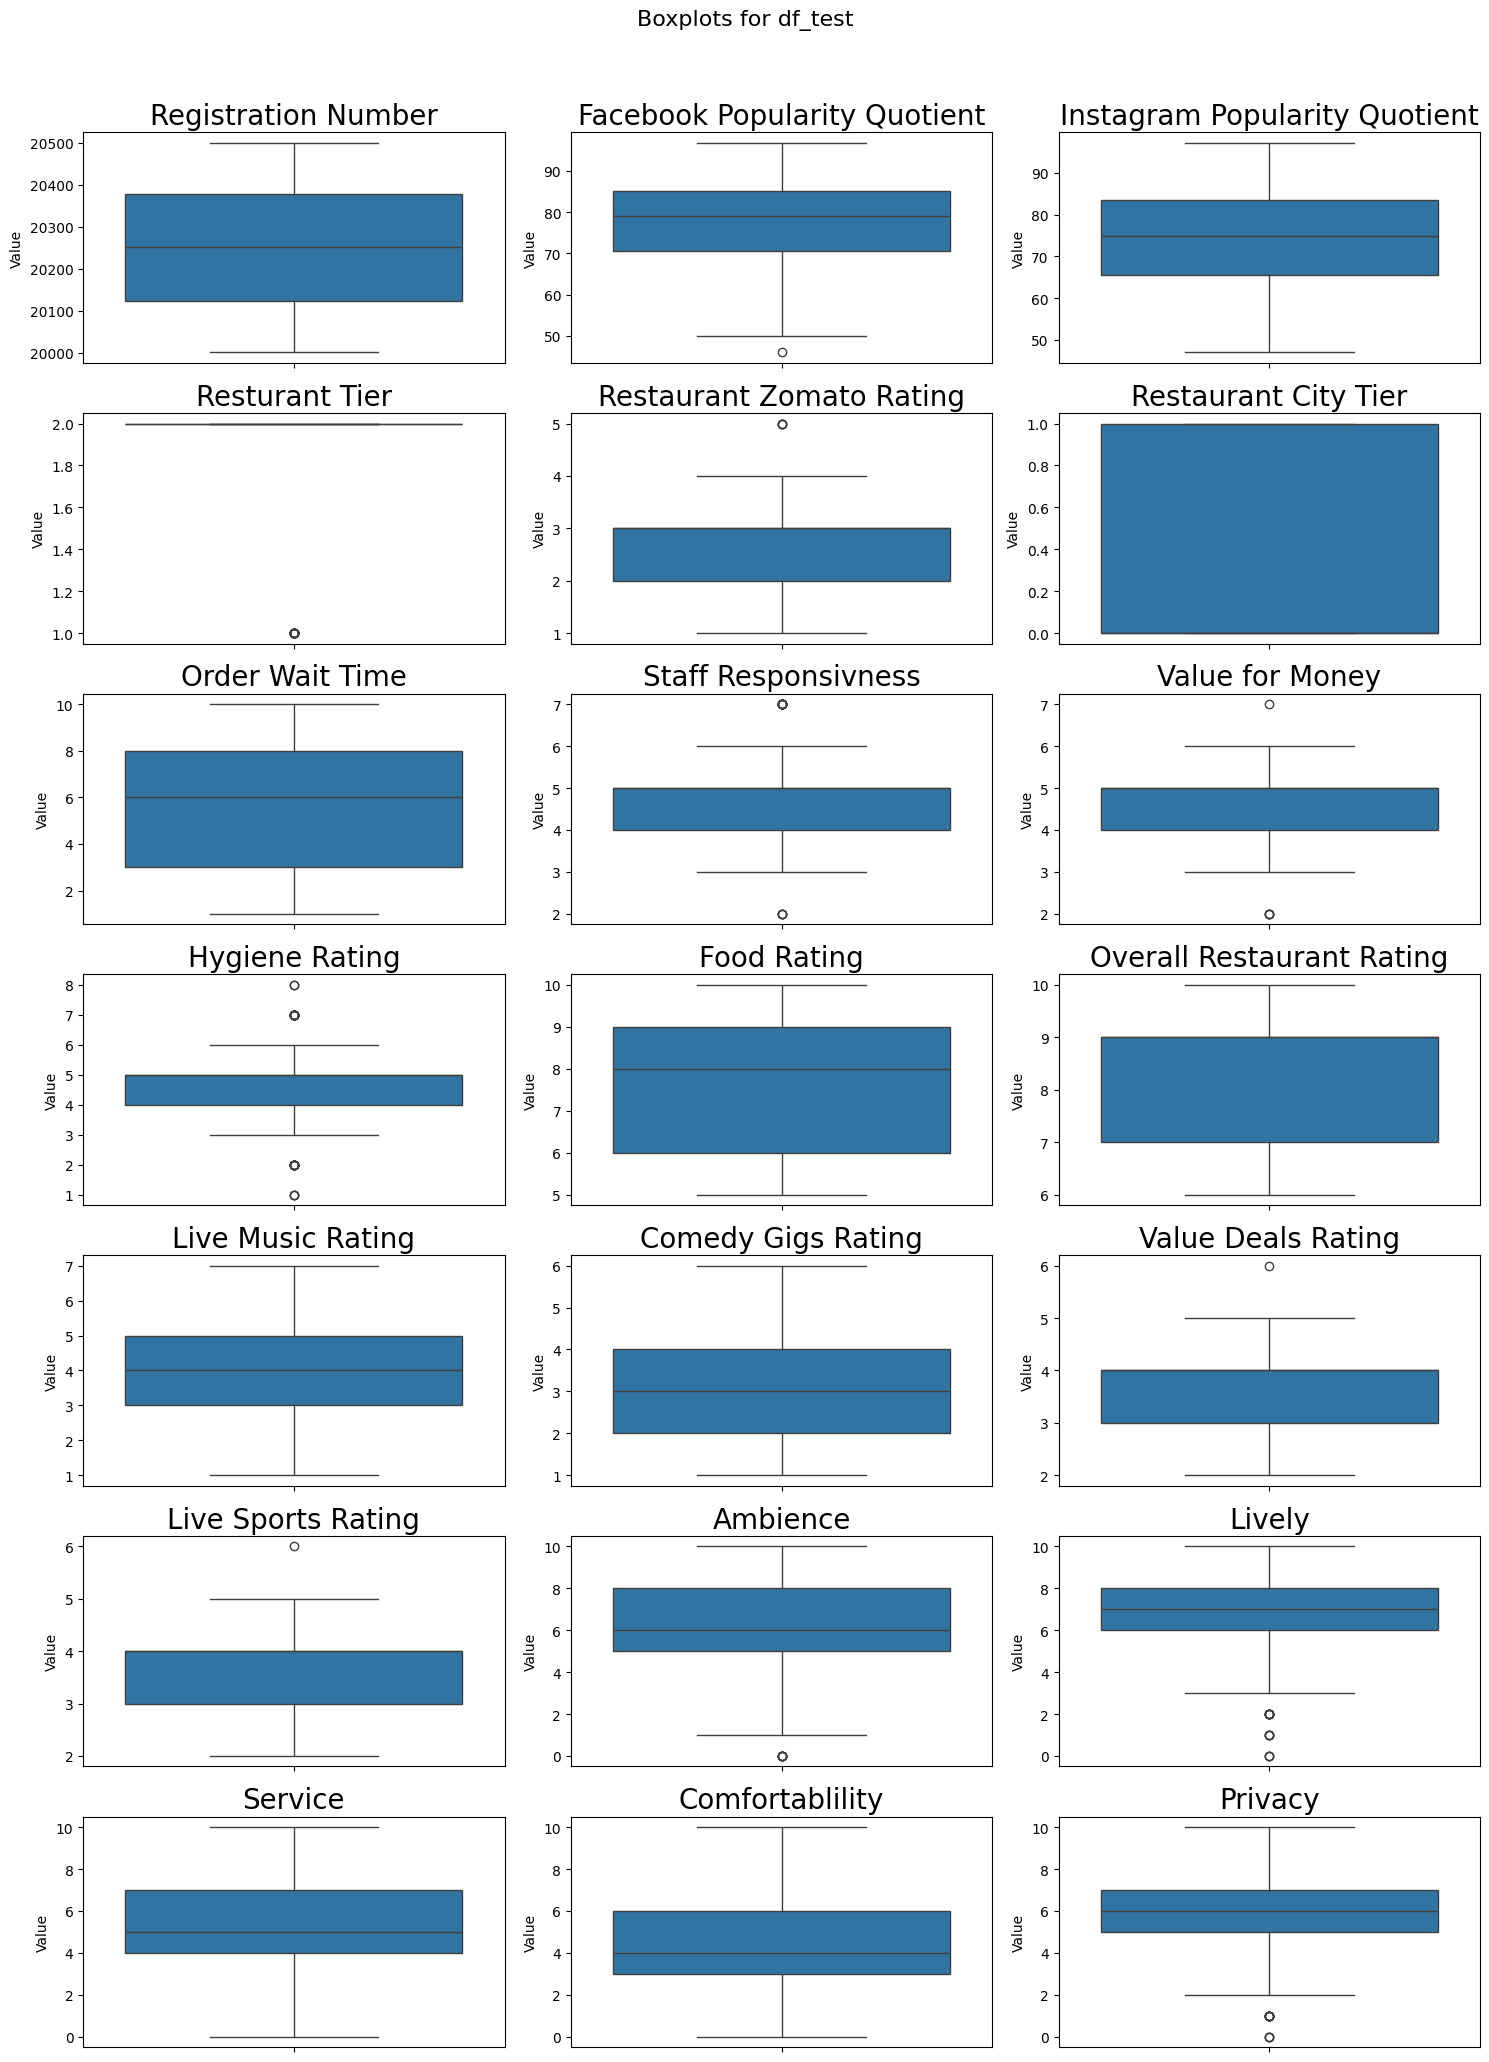

In [62]:
# Create boxplots for df_test
create_boxplots(df_test, 'Boxplots for df_test')

### Distribution of Categorical Features

## 3. Bivariate Analysis
- Numerical vs Numerical: Use scatter plots and pair plots.
- Numerical vs Categorical: Use box plots and violin plots.
- Categorical vs Categorical: Use cross-tabulations and heatmaps.

## 4. Multivariate Analysis
- Pair Plots: Visualize relationships between multiple numerical features.
- Heatmaps: Visualize correlations between multiple features.

## 5. Outlier Detection
- Box Plots: Identify outliers in numerical features.
- Z-Score or IQR: Use statistical methods to detect outliers.

## 6. Feature Engineering
- Create New Features: Based on domain knowledge or interactions between existing features.
- Transform Features: Apply log transformation, scaling, or encoding.

## 7. Target Variable Analysis
- Distribution: Examine the distribution of the target variable.
- Relationships: Analyze the relationship between the target variable and other features.

Metric to measure

The measure of accuracy will be RMSE (Root mean square error)

The predicted Annual Turnover for each restaurant in the Test dataset will be compared with the actual Annual Turnover to calculate the RMSE value of the entire prediction. The lower the RMSE value, the better the model will be.